# Dynamic computational graph for generalization bitty scientific data in universal model using behavior of cesium in «soil-plant» system as example

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset

## Dynamic computational graph for modelling Cs-137 behavior in a "soil-plant" system

In [2]:
# the model
# Parameters and equation minings see in Syntetic data generation
class soil_to_plant_cs_transfer(nn.Module):
  def __init__(self):
    super().__init__()
    self.a1_tr = nn.Parameter(torch.tensor([1], requires_grad=True, dtype=torch.float))
    self.a2_tr = nn.Parameter(torch.tensor([1], requires_grad=True, dtype=torch.float))
    self.b1_tr = nn.Parameter(torch.tensor([1], requires_grad=True, dtype=torch.float))
    self.b2_tr = nn.Parameter(torch.tensor([1], requires_grad=True, dtype=torch.float))
    self.KDl_tr = nn.Parameter(torch.tensor([1], requires_grad=True, dtype=torch.float))

  def forward(self, X): # DATA = 0:k_soil_train, 1:k_solution_train, 2:cs_soil_train, 3:cs_solution_train
    self.k_solution_hat = torch.tensor([np.nan], dtype=torch.float)
    self.cs_solution_hat = torch.tensor([np.nan], dtype=torch.float)
    self.CF_hat = torch.tensor([np.nan], dtype=torch.float)
    self.cs_plant_hat = torch.tensor([np.nan], dtype=torch.float)
    # programming different way of computation intermediate and final
    # values depending on completeness of training example
    if ~torch.isnan(X[:, 0]).any():
      self.k_solution_hat = self.a1_tr * X[:, 0] + self.a2_tr
    elif ~torch.isnan(X[:, 1]).any():
      self.k_solution_hat = X[:, 1]

    if ~torch.isnan(self.k_solution_hat).any():
      self.CF_hat = torch.pow(10, -1*(self.b1_tr * torch.log10(self.k_solution_hat) + self.b2_tr))

    if ~torch.isnan(X[:, 2]).any():
      self.cs_solution_hat = X[:, 2] / self.KDl_tr
    elif ~torch.isnan(X[:, 3]).any():
      self.cs_solution_hat = X[:, 3]

    if ~torch.isnan(self.CF_hat).any() and ~torch.isnan(self.cs_solution_hat).any():
      self.cs_plant_hat = self.CF_hat * self.cs_solution_hat

    return self.cs_plant_hat, self.cs_solution_hat, self.k_solution_hat, self.CF_hat

In [3]:
# Predict procedure for validation
def validating(k_soil_val, k_solution_val, cs_soil_val, cs_solution_val, cs_plant_val):
  val_data = samples_feed(k_soil_val, k_solution_val, cs_soil_val, cs_solution_val, cs_plant_val, shuffle=False)
  y = []
  y_hat = []
  for smp in range(int(len(val_data)/batch_size)):
    start = smp*batch_size
    finish = smp*batch_size+batch_size
    y_pred = model(val_data[start:finish][0])[0]
    if ~torch.isnan(y_pred.detach()).any() and ~torch.isnan(val_data[start:finish][1].detach()).any() :
      y.append(val_data[start:finish][1].detach())
      y_hat.append(y_pred.detach())
  return torch.tensor(y, dtype=torch.float), torch.tensor(y_hat, dtype=torch.float)

In [4]:
# train procedure
def make_train_step(model, loss_fn, optimizer):
  def train_step(features, labels):
    model.train()
    y_hat = model(features)
    loss_pl = loss_fn(labels, y_hat[0])
    loss_csol = loss_fn(features[:, 3], y_hat[1])
    loss_ksol = loss_fn(features[:, 1], y_hat[2])
    losses = []
    if not torch.isnan(loss_pl):
      losses.append(loss_pl)
    if not torch.isnan(loss_csol):
      losses.append(0.2 * loss_csol)
    if not torch.isnan(loss_ksol):
      losses.append(0.2 * loss_ksol)
    if len(losses) > 0:
      loss = sum(losses)
      try:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      except:
        pass
      return loss.item()
    else:
      return np.nan
  return train_step

In [5]:
# procedure for feeding the model with samples
class samples_feed(Dataset):
  def __init__(self, k_soil, k_solution, cs_soil, cs_solution, cs_plant, shuffle=True):
    self.x = np.hstack((k_soil, k_solution, cs_soil, cs_solution))
    self.y = cs_plant.flatten()
    self.n = cs_plant.size
    self.order = (np.arange(self.n))
    if shuffle:
      np.random.shuffle(self.order)

  def __getitem__(self, index):
    return (torch.tensor(self.x[self.order[index]], dtype=torch.float), torch.tensor(self.y[self.order[index]], dtype=torch.float))

  def __len__(self):
    return self.n  

## Syntetic data generation for test

We used very simplified model from Tarsitano, 2011 [doi:10.1016/j.jenvrad.2010.11.017](http://dx.doi.org/10.1016/j.jenvrad.2010.11.017).

In [6]:
np.random.seed(42)
a1 = 2451 # alpha in replaced A9
a2 = 4645 # beta in replaced A9
a3 = 69.2 # gamma in replaced A9
b1 = 1.64 # a1 in A8
b2 = 2.49 # a2 in A8
KDl = 134.8 # K_d for Cs-137
cs_soil = 500 + 2000 * np.random.rand(1000, 1) 
# activity concentration of Cs-137 in the soil, Bq/kg
k_soil = 0.1 + 0.6 * np.random.rand(1000, 1) 
# Exchange K^+ in soil, cmol/kg
k_solution = (k_soil / (a1 * (0.05+np.random.randn(1000, 1) * 0.007) + a2 * \
                        (0.05+np.random.randn(1000, 1) * 0.007)  - k_soil * a3)) + \
                        np.random.randn(1000, 1) * 0.00005
# K^+ in soil solution, mol/l
CF = np.power(10, -1*(b1 * np.log10(k_solution) + b2)) 
#  concentration factor from soil solution to plant for Cs-137
cs_solution = cs_soil / (KDl + np.random.randn(1000, 1) * 30)
# Cs-137 in soil solution, Bq/l
cs_plant = CF * cs_solution + (np.random.randn(1000, 1) * 0.5)
# Activity concentration of Cs-137 in plant, Bq/kg

# combine all in DataFrame
data = pd.DataFrame({'cs_soil': cs_soil.reshape(-1), 
                     'k_soil': k_soil.reshape(-1), 
                     'k_solution': k_solution.reshape(-1), 
                     'cs_solution': cs_solution.reshape(-1), 
                     'cs_plant': cs_plant.reshape(-1), 
                     'CF': CF.reshape(-1)}, index=np.arange(1000))


In [7]:
# Data normalization
cs_soil = cs_soil / cs_soil.mean()
k_soil = k_soil / k_soil.mean()
k_solution = k_solution / k_solution.mean()
CF = CF / CF.mean()
cs_solution = cs_solution / cs_solution.mean()
cs_plant = cs_plant / cs_plant.max()

In [8]:
# Remove some values from the dataset for mimic sparce scientific data
idx = np.arange(1000)

np.random.shuffle(idx)
non_idx = idx[:200]
cs_solution[non_idx] = np.nan

np.random.shuffle(idx)
non_idx = idx[:200]
k_solution[non_idx] = np.nan

np.random.shuffle(idx)
non_idx = idx[:200]
k_soil[non_idx] = np.nan

np.random.shuffle(idx)
non_idx = idx[:50]
cs_soil[non_idx] = np.nan

np.random.shuffle(idx)
non_idx = idx[:50]
cs_plant[non_idx] = np.nan

In [9]:
# Split data on train and validation sets
np.random.shuffle(idx)
train_idx = idx[:800]
val_idx = idx[800:]

cs_soil_train, k_soil_train, k_solution_train, CF_train, cs_solution_train, cs_plant_train = cs_soil[train_idx], k_soil[train_idx], k_solution[train_idx], CF[train_idx], cs_solution[train_idx], cs_plant[train_idx]

cs_soil_val, k_soil_val, k_solution_val, CF_val, cs_solution_val, cs_plant_val = cs_soil[val_idx], k_soil[val_idx], k_solution[val_idx], CF[val_idx], cs_solution[val_idx], cs_plant[val_idx]

## Train the model

In [10]:
lr = 3e-3
n_epoch = 100 #1000
model = soil_to_plant_cs_transfer()
optimizer = optim.Adam(params=model.parameters(), lr=lr) # SGD, Adam, Adadelta lr = 1.0
loss_fn = nn.MSELoss(reduction='mean')
#loss_fn = nn.L1Loss(reduction='mean')
batch_size=1 # each sample may have unique composition of parameters, so we have to tune the model for each sample

In [11]:
# iterator with train data
train_step = make_train_step(model, loss_fn, optimizer)
losses_train = []
losses_val = []

In [12]:
# training the model
for epoch in range(n_epoch):
  train_data = samples_feed(k_soil_train, k_solution_train, cs_soil_train, cs_solution_train, cs_plant_train)
  ep_loss = []

  for smp in range(int(len(train_data)/batch_size)):
    start = smp*batch_size
    finish = smp*batch_size+batch_size
    loss = train_step(train_data[start:finish][0], train_data[start:finish][1])
    ep_loss.append(loss)

  ty, ty_hat = validating(k_soil_train, k_solution_train, cs_soil_train, cs_solution_train, cs_plant_train)
  losses_train.append(loss_fn(ty, ty_hat))
  yy, yy_hat = validating(k_soil_val, k_solution_val, cs_soil_val, cs_solution_val, cs_plant_val)  
  losses_val.append(loss_fn(yy, yy_hat))

In [13]:
print(f'losses - train: {losses_train[-1]}, validate: {losses_val[-1]}')

losses - train: 0.002337789162993431, validate: 0.0014451451133936644


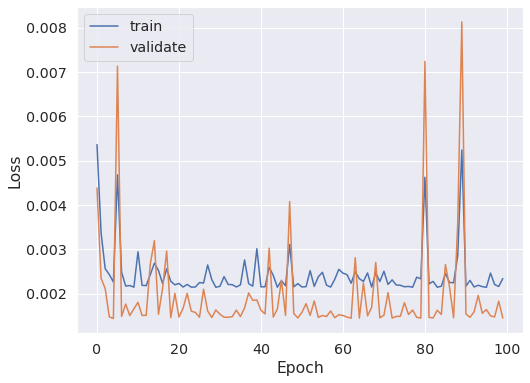

In [14]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.lineplot(data=np.array(losses_train), label='train')
sns.lineplot(data=np.array(losses_val), label='validate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The model has very small set of parameters and finish training in several epoch. Probably it is sensitive for some samples and loss value unstable through the epoches.

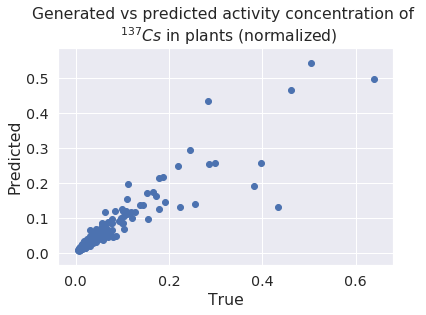

In [15]:
yy, yy_hat = validating(k_soil_val, k_solution_val, cs_soil_val, cs_solution_val, cs_plant_val)
plt.scatter(yy, yy_hat)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Generated vs predicted activity concentration of \n $^{137}Cs$ in plants (normalized)')
plt.show()


[Conference paper (in Russian)](https://www.researchgate.net/publication/341757184_DYNAMIC_COMPUTATIONAL_GRAPH_FOR_GENERALIZATION_BITTY_SCIENTIFIC_DATA_IN_UNIVERSAL_MODEL_USING_BEHAVIOR_OF_CESIUM_IN_SOIL-PLANT_SYSTEM_AS_EXAMPLE#fullTextFileContent)